In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# MNIST IMAGE --> TENSOR
transform = transforms.ToTensor()

In [58]:
# data to load
train_data = datasets.MNIST(root='../../Data', train = True, download= True, transform=transform)
test_data = datasets.MNIST(root='../../Data', train = False, download= True, transform=transform)

In [59]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle = True)
test_loader = DataLoader(test_data, batch_size=10, shuffle = False)

# define convolutional model

In [60]:
conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1)


In [61]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [62]:
X_train.shape # ---> should be 4d (batch size 10)

torch.Size([1, 28, 28])

In [63]:
x = X_train.view(1,1,28,28)

In [64]:
x = conv1(x)
x = F.relu(x)

In [65]:
x.shape

torch.Size([1, 6, 26, 26])

In [66]:
 x = F.max_pool2d(x, kernel_size = 2, stride = 2)

In [67]:
x.shape

torch.Size([1, 6, 13, 13])

In [68]:
x = conv2(x)
x = F.relu(x)

In [69]:
x.shape

torch.Size([1, 16, 11, 11])

In [70]:
 x = F.max_pool2d(x, kernel_size = 2, stride = 2)

In [71]:
x.shape

torch.Size([1, 16, 5, 5])

In [72]:
(((28-2)/2) - 2) /2

5.5

In [73]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

# creating model class


In [74]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 16*5*5)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [75]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [76]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [78]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.19477190  accuracy:  78.583%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.63014543  accuracy:  85.725%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01575714  accuracy:  88.728%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02389385  accuracy:  90.492%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00737841  accuracy:  91.603%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.01266039  accuracy:  92.403%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.05842144  accuracy:  92.993%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00304698  accuracy:  93.515%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00043986  accuracy:  93.946%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00279448  accuracy:  94.273%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01315470  accuracy:  97.983%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.26916158  accuracy:  97.825%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.12557010  accuracy:  97.828%
epoch:  1  b

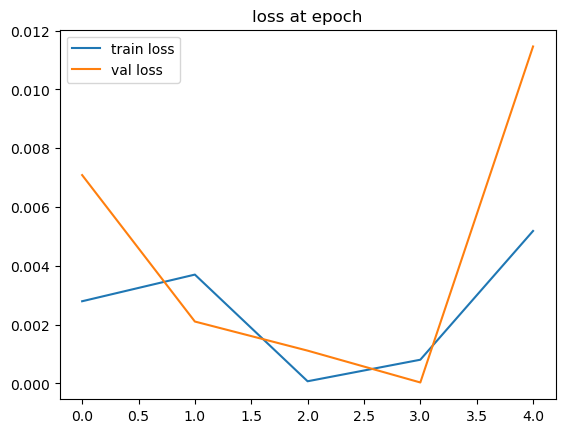

In [79]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label ='val loss')
plt.title('loss at epoch')
plt.legend()

In [81]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)
with torch.no_grad():
    correct = 0
    for X_test, y_test, in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        

In [82]:
correct.item()/len(test_data)

0.9847